(4688, 2568)


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

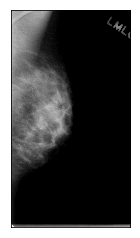

In [2]:
import numpy as np
import cv2
import skimage
from skimage.exposure import equalize_hist
from skimage.filters.rank import median
from skimage.measure import regionprops
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb
from skimage.transform import rescale
from scipy.ndimage import binary_fill_holes
from scipy.misc import imresize
from matplotlib import pyplot as plt
from PIL import Image

def breast_segment(im, scale_factor=0.25, threshold=3900, felzenzwalb_scale=0.15):
    """
    Fully automated breast segmentation in mammographies.
    <scale_factor>: Scale Factor
    <threshold>: Threshold
    <felzenzwalb_scale>: Felzenzwalb Scale
    return: (im_mask, bbox) where im_mask is the segmentation mask and
    bbox is the bounding box (rectangular) of the segmentation.
    """

    # set threshold to remove artifacts around edges
    im_thres = im.copy()
    im_thres[im_thres > threshold] = 0

    # determine breast side
    col_sums_split = np.array_split(np.sum(im_thres, axis=0), 2)
    left_col_sum = np.sum(col_sums_split[0])
    right_col_sum = np.sum(col_sums_split[1])

    if left_col_sum > right_col_sum:
        breast_side = 'l'
    else:
        breast_side = 'r'

    # rescale and filter aggressively, normalize
    im_small = rescale(im_thres, scale_factor)
    im_small_filt = median(im_small, disk(50))
    # this might not be helping, actually sometimes it is
    im_small_filt = equalize_hist(im_small_filt)

    # run mr. felzenzwalb
    segments = felzenszwalb(im_small_filt, scale=felzenzwalb_scale)
    segments += 1  # otherwise, labels() would ignore segment with segment=0


    props = regionprops(segments)

    # Sort Props by area, descending
    props_sorted = sorted(props, key=lambda x: x.area, reverse=True)

    expected_bg_index = 0
    bg_index = expected_bg_index

    bg_region = props_sorted[bg_index]
    minr, minc, maxr, maxc = bg_region.bbox
    filled_mask = bg_region.filled_image

    im_small_fill = np.zeros((im_small_filt.shape[0]+2, im_small_filt.shape[1]+1), dtype=int)

    if breast_side == 'l':
        # breast expected to be on left side,
        # pad on right and bottom side
        im_small_fill[minr+1:maxr+1, minc:maxc] = filled_mask
        im_small_fill[0, :] = 1  # top
        im_small_fill[-1, :] = 1  # bottom
        im_small_fill[:, -1] = 1  # right
    elif breast_side == 'r':
        # breast expected to be on right side,
        # pad on left and bottom side
        im_small_fill[minr+1:maxr+1, minc+1:maxc+1] = filled_mask  # shift mask to right side
        im_small_fill[0, :] = 1  # top
        im_small_fill[-1, :] = 1  # bottom
        im_small_fill[:, 0] = 1  # left

    im_small_fill = binary_fill_holes(im_small_fill)

    im_small_mask = im_small_fill[1:-1, :-1] if breast_side == 'l' \
                  else im_small_fill[1:-1, 1:]

    # rescale mask
    #im_mask = imresize(im_small_mask, im.shape).astype(bool)
    im_mask = skimage.transform.resize(im_small_mask, im.shape).astype(bool)

    # invert!
    im_mask = ~im_mask

    # determine side of breast in mask and compare
    col_sums_split = np.array_split(np.sum(im_mask, axis=0), 2)
    left_col_sum = np.sum(col_sums_split[0])
    right_col_sum = np.sum(col_sums_split[1])

    if left_col_sum > right_col_sum:
        breast_side_mask = 'l'
    else:
        breast_side_mask = 'r'

    if breast_side_mask != breast_side:
        # breast mask is not on expected side
        # we might have segmented bg instead of breast
        # so invert again
        print('breast and mask side mismatch. inverting!')
        im_mask = ~im_mask

    # exclude thresholded area (artifacts) in mask, too
    im_mask[im > threshold] = False

    # fill holes again, just in case there was a high-intensity region
    # in the breast
    im_mask = binary_fill_holes(im_mask)

    # if no region found, abort early and return mask of complete image
    if im_mask.ravel().sum() == 0:
        all_mask = np.ones_like(im).astype(bool)
        bbox = (0, 0, im.shape[0], im.shape[1])
        print('Couldn\'t find any segment')
        return all_mask, bbox

    # get bbox
    minr = np.argwhere(im_mask.any(axis=1)).ravel()[0]
    maxr = np.argwhere(im_mask.any(axis=1)).ravel()[-1]
    minc = np.argwhere(im_mask.any(axis=0)).ravel()[0]
    maxc = np.argwhere(im_mask.any(axis=0)).ravel()[-1]

    bbox = (minr, minc, maxr, maxc)

    return im_mask, bbox

#im = cv2.imread('/Users/sunying/Desktop/db3/full/jpg/1+Calc-Training_P_00112_RIGHT_CC.jpg',0) 
im = cv2.imread('/Users/sunying/Desktop/db3/full/jpg/0+Calc-Training_P_00020_LEFT_MLO.jpg',0)
print(im.shape)
plt.imshow(im,'gray')
plt.xticks([]),plt.yticks([])
#im_crop = im[minr:maxr, minc:maxc]
#plt.imshow(im_crop,'gray')

(array([8288090.,  372620.,  426240.,  723910.,  972805.,  738353.,
         419741.,   72363.,   10244.,   14418.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

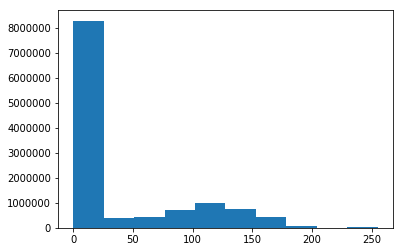

In [3]:
plt.hist(im.ravel())

In [4]:
mask, bbox = breast_segment(im)

/Users/sunying/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sunying/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


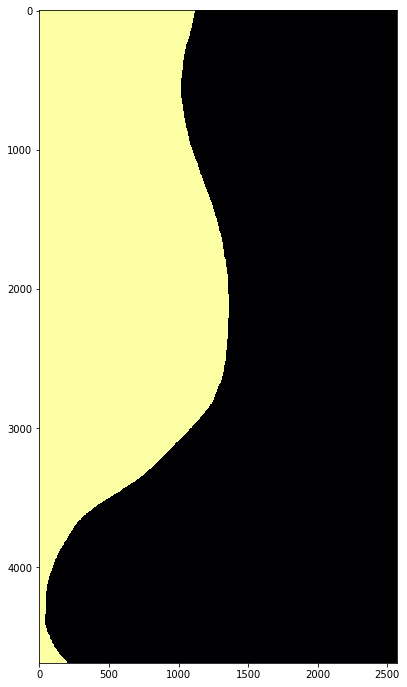

In [5]:
f, ax = plt.subplots(1, figsize=(12, 12)) # adjust the figure size
# set the correct window and color map.
# radiologists like gray, not understandably
#ax.imshow(mask, cmap='inferno')
ax.imshow(mask, vmin=0, vmax=1, cmap='inferno') # use inferno colormap for dramatisation


In [8]:
print(bbox)

(0, 0, 4687, 1361)


In [9]:
def bbox_lines(im, bbox):
    # destructure the bbox as into columns and rows, see above
    minr, minc, maxr, maxc = bbox
    line_left = mlines.Line2D([minc, minc], [0, im.shape[0]], color='y', lw=2, alpha=.5)
    line_right = mlines.Line2D([maxc, maxc], [0, im.shape[0]], color='y', lw=2, alpha=.5)
    line_top = mlines.Line2D([0, im.shape[1]], [minr, minr], color='y', lw=2, alpha=.5)
    line_bot = mlines.Line2D([0, im.shape[1]], [maxr, maxr], color='y', lw=2, alpha=.5)
    
    return line_left, line_right, line_top, line_bot

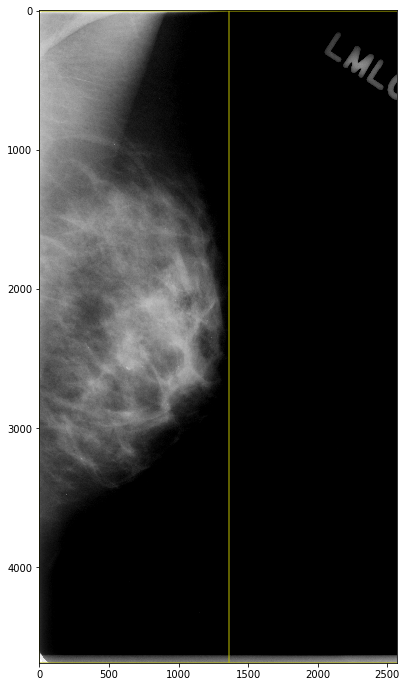

In [10]:
# let's plot it! .. in yellow
from PIL import Image
import matplotlib.lines as mlines
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(im, cmap='gray')
#minr, minc, maxr, maxc = bbox
lines = bbox_lines(im, bbox)
[ax.add_line(l) for l in lines]

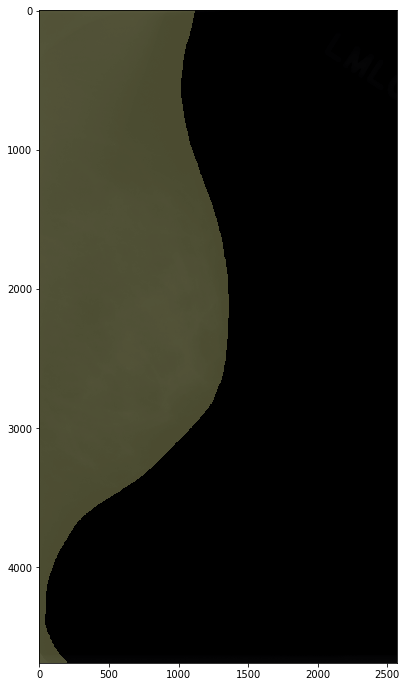

In [11]:
# one last thing: how about an overlay?
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(im, vmin=0, vmax=4096, cmap='gray')
#ax.imshow(im,cmap='gray')
ax.imshow(mask, alpha=.3, cmap='inferno') # alpha controls the transparency

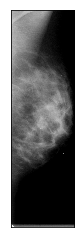

In [16]:
minr, minc, maxr, maxc = bbox
im_crop = im[minr:maxr, minc:maxc]
plt.imshow(im_crop,'gray')
plt.xticks([])
plt.yticks([])
img= im_crop

Iteration 0 : cost = 7678429.655157
Iteration 1 : cost = 7769.201921
Iteration 2 : cost = 108307.112071
Iteration 3 : cost = 966415.121764
Iteration 4 : cost = 2680924.618184
Iteration 5 : cost = 1577162.222838
Iteration 6 : cost = 1161880.801750
Iteration 7 : cost = 205389.807886
Iteration 8 : cost = 35352.538148
Iteration 9 : cost = 16335.423530
Iteration 10 : cost = 12143.788343
Iteration 11 : cost = 9077.229178
Iteration 12 : cost = 6790.643180
Iteration 13 : cost = 5081.866342
Iteration 14 : cost = 3804.248473
Iteration 15 : cost = 2848.510608
Iteration 16 : cost = 2133.261914
Iteration 17 : cost = 1597.820210
Iteration 18 : cost = 1196.889788
Iteration 19 : cost = 896.627323
Iteration 20 : cost = 671.727675
Iteration 21 : cost = 503.259513
Iteration 22 : cost = 377.054199
Iteration 23 : cost = 282.504460
Iteration 24 : cost = 211.667468
Iteration 25 : cost = 158.594588
Iteration 26 : cost = 118.830161
Iteration 27 : cost = 89.036494
Iteration 28 : cost = 66.713189
Iteration 29 : 

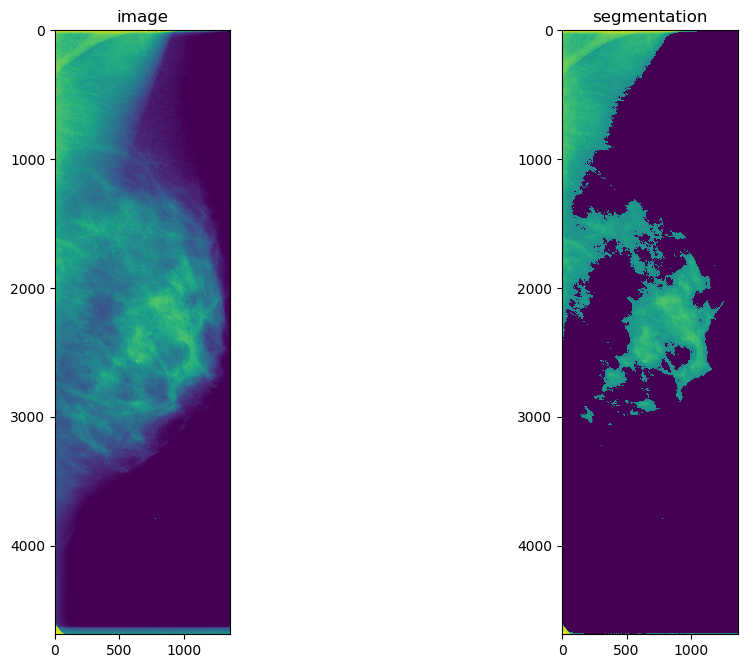

In [64]:
from numpy import *
import numpy as np
import cv2
img=cv2.imread('/Users/sunying/Desktop/cut.jpg',0)
laplace=cv2.Laplacian(img,cv2.CV_16S,ksize=5)
laplacian=cv2.convertScaleAbs(laplace)


import numpy as np
from scipy import signal



def getGaussianElement(a,b,stda,stdb,quad=None):
    '''Create a 2d gussian weight kernel
    <a>: int, half major axis length.
    <b>: int, half minor axis length.
    <stda>, <stdb>: floats, standard deviations on x and y axis.
    <quad>: str or None. If str, choose one in the list:
            ['ne','nw','sw','se'], specifying the quadrant.
            If None, return whole disk.
    Return <ellipse>: 2d int array, gaussian weights following:
    
        f(x,y) = 1/2/pi/stda/stdb * exp(- x**2/2/stda**2 - y**2/2/stdb**2).
    '''

    assert a>0 and int(a)==a, "Major half-axis 'a' needs to be an positive integer."
    assert b>0 and int(b)==b, "Minor half-axis 'b' needs to be an positive integer."
    assert stda>0, "Standard deviation 'stda' needs to be an positive integer."
    assert stdb>0, "Standard deviation 'stdb' needs to be an positive integer."
    assert quad in [None,'ne','nw','sw','se'], "Quadrant should be one in the list [None, 'ne','nw','sw','se']."

    ax=np.arange(-a,a+1)
    bx=np.arange(-b,b+1)
    x,y=np.meshgrid(ax,bx)
    ellipse=0.5*np.pi/stda/stdb*np.exp(-x**2/2./stda**2 - y**2/2./stdb**2)

    if quad is not None:
        if quad=='ne':
            ellipse=np.where((ellipse>0) & (x>=0) & (y>=0),ellipse,0)
        elif quad=='nw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y>=0),ellipse,0)
        elif quad=='sw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y<=0),ellipse,0)
        elif quad=='se':
            ellipse=np.where((ellipse>0) & (x>=0) & (y<=0),ellipse,0)

    #--------------------Normalize--------------------
    ellipse=ellipse/np.max(ellipse)

    return ellipse



class FCM():
    def __init__(self,image,n_clusters,m=2,kernel_size=5,
            kernel_shape='uniform',lam=0.5,epsilon=0.05,max_iter=300):
        '''Spatial intuitionistic Fuzzy C-means clustering on image
        <image>: 2D array, grey scale image. Can be of int type or float.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <kernel_size>: int >= 1, size of neighborhood.
        <kernel_shape>: str, 'uniform': equally weighted kernel function in
                                        summing weights in neighborhood.
                             'gaussian': gaussian weights for summing neighborhood.
        <lam>: float > 0, intuitionistic fuzzy parameter?
        <epsilon>: float > 0, threshold to check convergence.
        <max_iter>: int, max number of iterations.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if kernel_size <=0 or kernel_size != int(kernel_size):
            raise Exception("<kernel_size> needs to be positive integer.")
        if kernel_shape not in ['uniform', 'gaussian']:
            raise Exception("<kernel_shape> needs to be one of 'uniform', 'gaussian'.")
        if lam <= 0:
            raise Exception("<lam> needs to be > 0.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.kernel_size = kernel_size
        self.kernel_shape = kernel_shape
        self.lam = lam
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size
        

        #-----------------Initial weights-----------------
        self.U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            self.U[idxii,ii] = 1

        #-----------------Initial centers-----------------
        self.C = np.linspace(np.min(image),np.max(image),n_clusters)
        self.C = self.C.reshape(self.n_clusters,1)
        
         
            

        #---------------Neighbourhood kernel---------------
        if kernel_shape == 'uniform':
            self.kernel = np.ones([kernel_size,kernel_size,1])
        if kernel_shape == 'gaussian':
            radius = max(1,int(kernel_size/.2))
            stdr = max(1,int(radius/.2))
            self.kernel = getGaussianElement(radius,radius,stdr,stdr)

        #----------------Initial hesitation----------------
        self.hesitation = 1.-self.U-(1.-self.U)/(1.+2.*self.U)


    def update_U(self):
        '''Compute weights'''
        c_mesh,x_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(x_mesh-c_mesh)**power
        p2 = np.sum((1./abs(x_mesh-c_mesh))**power,axis=1)

        return 1./(p1*p2[:,None])


    def update_C(self):
        '''Compute centroid of clusters'''
        num = np.dot(self.X,self.U**self.m)
        den = np.sum(self.U**self.m,axis=0)

        return num/den


    def calculate_h(self):
        '''Compute neighbourhood weights'''
        kernel = np.ones((5,5,1))
        uu = self.U.reshape((self.shape+(self.n_clusters,)))
        h = signal.fftconvolve(uu,kernel,mode='same')
        h = h.reshape(self.U.shape)

        return h

    def compute_intuitionistic_U(self):
        '''Compute intuitionistic U'''
        self.hesitation=1.-self.U-(1-self.U)/(1+self.lam*self.U)

        return self.U+self.hesitation


    def computeNew_U(self):
        '''Compute new weights after incorporating spatial and intuitionistic'''
        p = 1
        #q = 2
        q = 3
        self.h = self.calculate_h()
        num=self.U**p*self.h**q
        denom=num.sum(axis=1)
        denom=np.outer(denom,1+np.arange(self.n_clusters))

        return num/denom


    def computeIntraDists(self):
        '''Compute mean intra cluster distances'''

        result = self.deFuzzify()
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        dist=abs(c_mesh-x_mesh)
        idx=np.arange(self.n_clusters)
        match=result[:,None]-idx[None,:]
        _,count=np.unique(self.result,return_counts=True)
        sigma=(dist*(match==0)).sum(axis=0)/count

        return sigma


    def calculate_DB_score(self):
        '''Compute DB index
        DB = 1/c * \sum_{1}^{c} max_{i != j} ( (s_i + s_j) / d_{i,j} )
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        c is the number of clusters
        '''

        sigmas = self.computeIntraDists()

        rs=sigmas[:,None]+sigmas[None,:]
        dists=abs(self.C[:,None]-self.C[None,:])
        np.fill_diagonal(dists,np.nan)
        rs=rs/dists
        ds=np.nanmax(rs,axis=0)
        DB_score=ds.sum()/self.n_clusters

        print("DB_score = %f" %DB_score)

    def calculate_D_score(self):
        '''Compute Dunn index
        D = min{ min { d_{i,j} / max {s_k} } }
        the ratio of min inter-cluster distance to max  intra-cluster distance
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        '''

        sigmas = self.computeIntraDists()

        denom=np.max(sigmas)
        dists=abs(self.C[:,None]-self.C[None,:])/denom
        np.fill_diagonal(dists,np.inf)
        D_score=np.min(dists)

        print("D_score = %f" %D_score)


    def calculate_scores(self):

        #--------------Partition coefficient--------------
        self.vpc=(self.U**2).sum()/self.numPixels
        print("VPC =  %f" %self.vpc)

        #----------------Partition entropy----------------
        vpe=self.U*np.log(self.U)
        self.vpe=-1*vpe.sum()/self.numPixels
        print("VPE = %f" %self.vpe)

        #------------------Cost function------------------
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        numer=(self.U*(x_mesh-c_mesh)**2).sum()
        denom=self.numPixels*(self.C[0]-self.C[1])**2
        self.vxb=numer/denom
        print("VXB = %f" %self.vxb)

        #-------------DB scorea nd Dunn index-------------
        self.calculate_DB_score()
        self.calculate_D_score()


    def form_clusters(self):
        '''Iterative training'''
        d = 100
        if self.max_iter != -1:
            i = 0
            while True:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                self.U = self.compute_intuitionistic_U()
                self.U = self.computeNew_U()
                #d = sum(abs(sum(self.U_new - old_u)))
                # this way of computing d is faster
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
                #print(self.U)
        else:
            i = 0
            while d > self.epsilon:
                self.update_C()
                old_u = np.copy(self.U)
                self.update_U()
                d = sum(abs(sum(self.U - old_u)))
                print("loop : " , int(i))
                print(d)
                self.segmentImage(i)
                i+=1
        #print(self.shape)
        self.segmentImage()

    def deFuzzify(self):
        #return np.argmax(self.U[:,1], axis = 0)
        return np.argmax(self.U, axis = 1)

    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        #self.result = result
        self.result = result.reshape(self.shape).astype('int')
        
        for i in range(1,len(self.result)):
            for j in range(1,len(self.result[1])):
                if self.result[int(i)][int(j)] != 1:
                    self.result[int(i)][int(j)] = 0
                    
        return self.result




if __name__ == '__main__':

    from skimage import data

    #img=data.imread('brainMRI.jpg',as_grey=True)
    
    #img=data.imread('im_crop',as_grey=True)
    img = im_crop
   
    #print(img)
    
    #img = laplacian

    cluster = FCM(img,3,m=2,epsilon=.05,max_iter=100,kernel_shape='gaussian',
            kernel_size=9)
    cluster.form_clusters()
    cluster.calculate_scores()
    result=cluster.result
    #print(result.shape)
    
    result1=multiply(mat(img),mat(result))
    #-------------------Plot------------------------
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(12,8),dpi=100)

    ax1=fig.add_subplot(1,2,1)
    ax1.imshow(img)
    ax1.set_title('image')

    ax2=fig.add_subplot(1,2,2)
    ax2.imshow(result1)
    ax2.set_title('segmentation')

    plt.show(block=False)
        

Iteration 0 : cost = 16611008.168302
Iteration 1 : cost = 108555.870528
Iteration 2 : cost = 627062.653715
Iteration 3 : cost = 5451513.304559
Iteration 4 : cost = 7759150.323409
Iteration 5 : cost = 1162962.606305
Iteration 6 : cost = 498261.240058
Iteration 7 : cost = 181467.321421
Iteration 8 : cost = 115617.180076
Iteration 9 : cost = 90192.658104
Iteration 10 : cost = 79505.828011
Iteration 11 : cost = 72371.174029
Iteration 12 : cost = 65470.346615
Iteration 13 : cost = 58289.335184
Iteration 14 : cost = 51076.571456
Iteration 15 : cost = 44161.687992
Iteration 16 : cost = 37781.791105
Iteration 17 : cost = 32062.326676
Iteration 18 : cost = 27044.985393
Iteration 19 : cost = 22712.922812
Iteration 20 : cost = 19016.132742
Iteration 21 : cost = 15887.311158
Iteration 22 : cost = 13254.792750
Iteration 23 : cost = 11048.804390
Iteration 24 : cost = 9205.210061
Iteration 25 : cost = 7667.140661
Iteration 26 : cost = 6385.331391
Iteration 27 : cost = 5317.744604
Iteration 28 : cost 

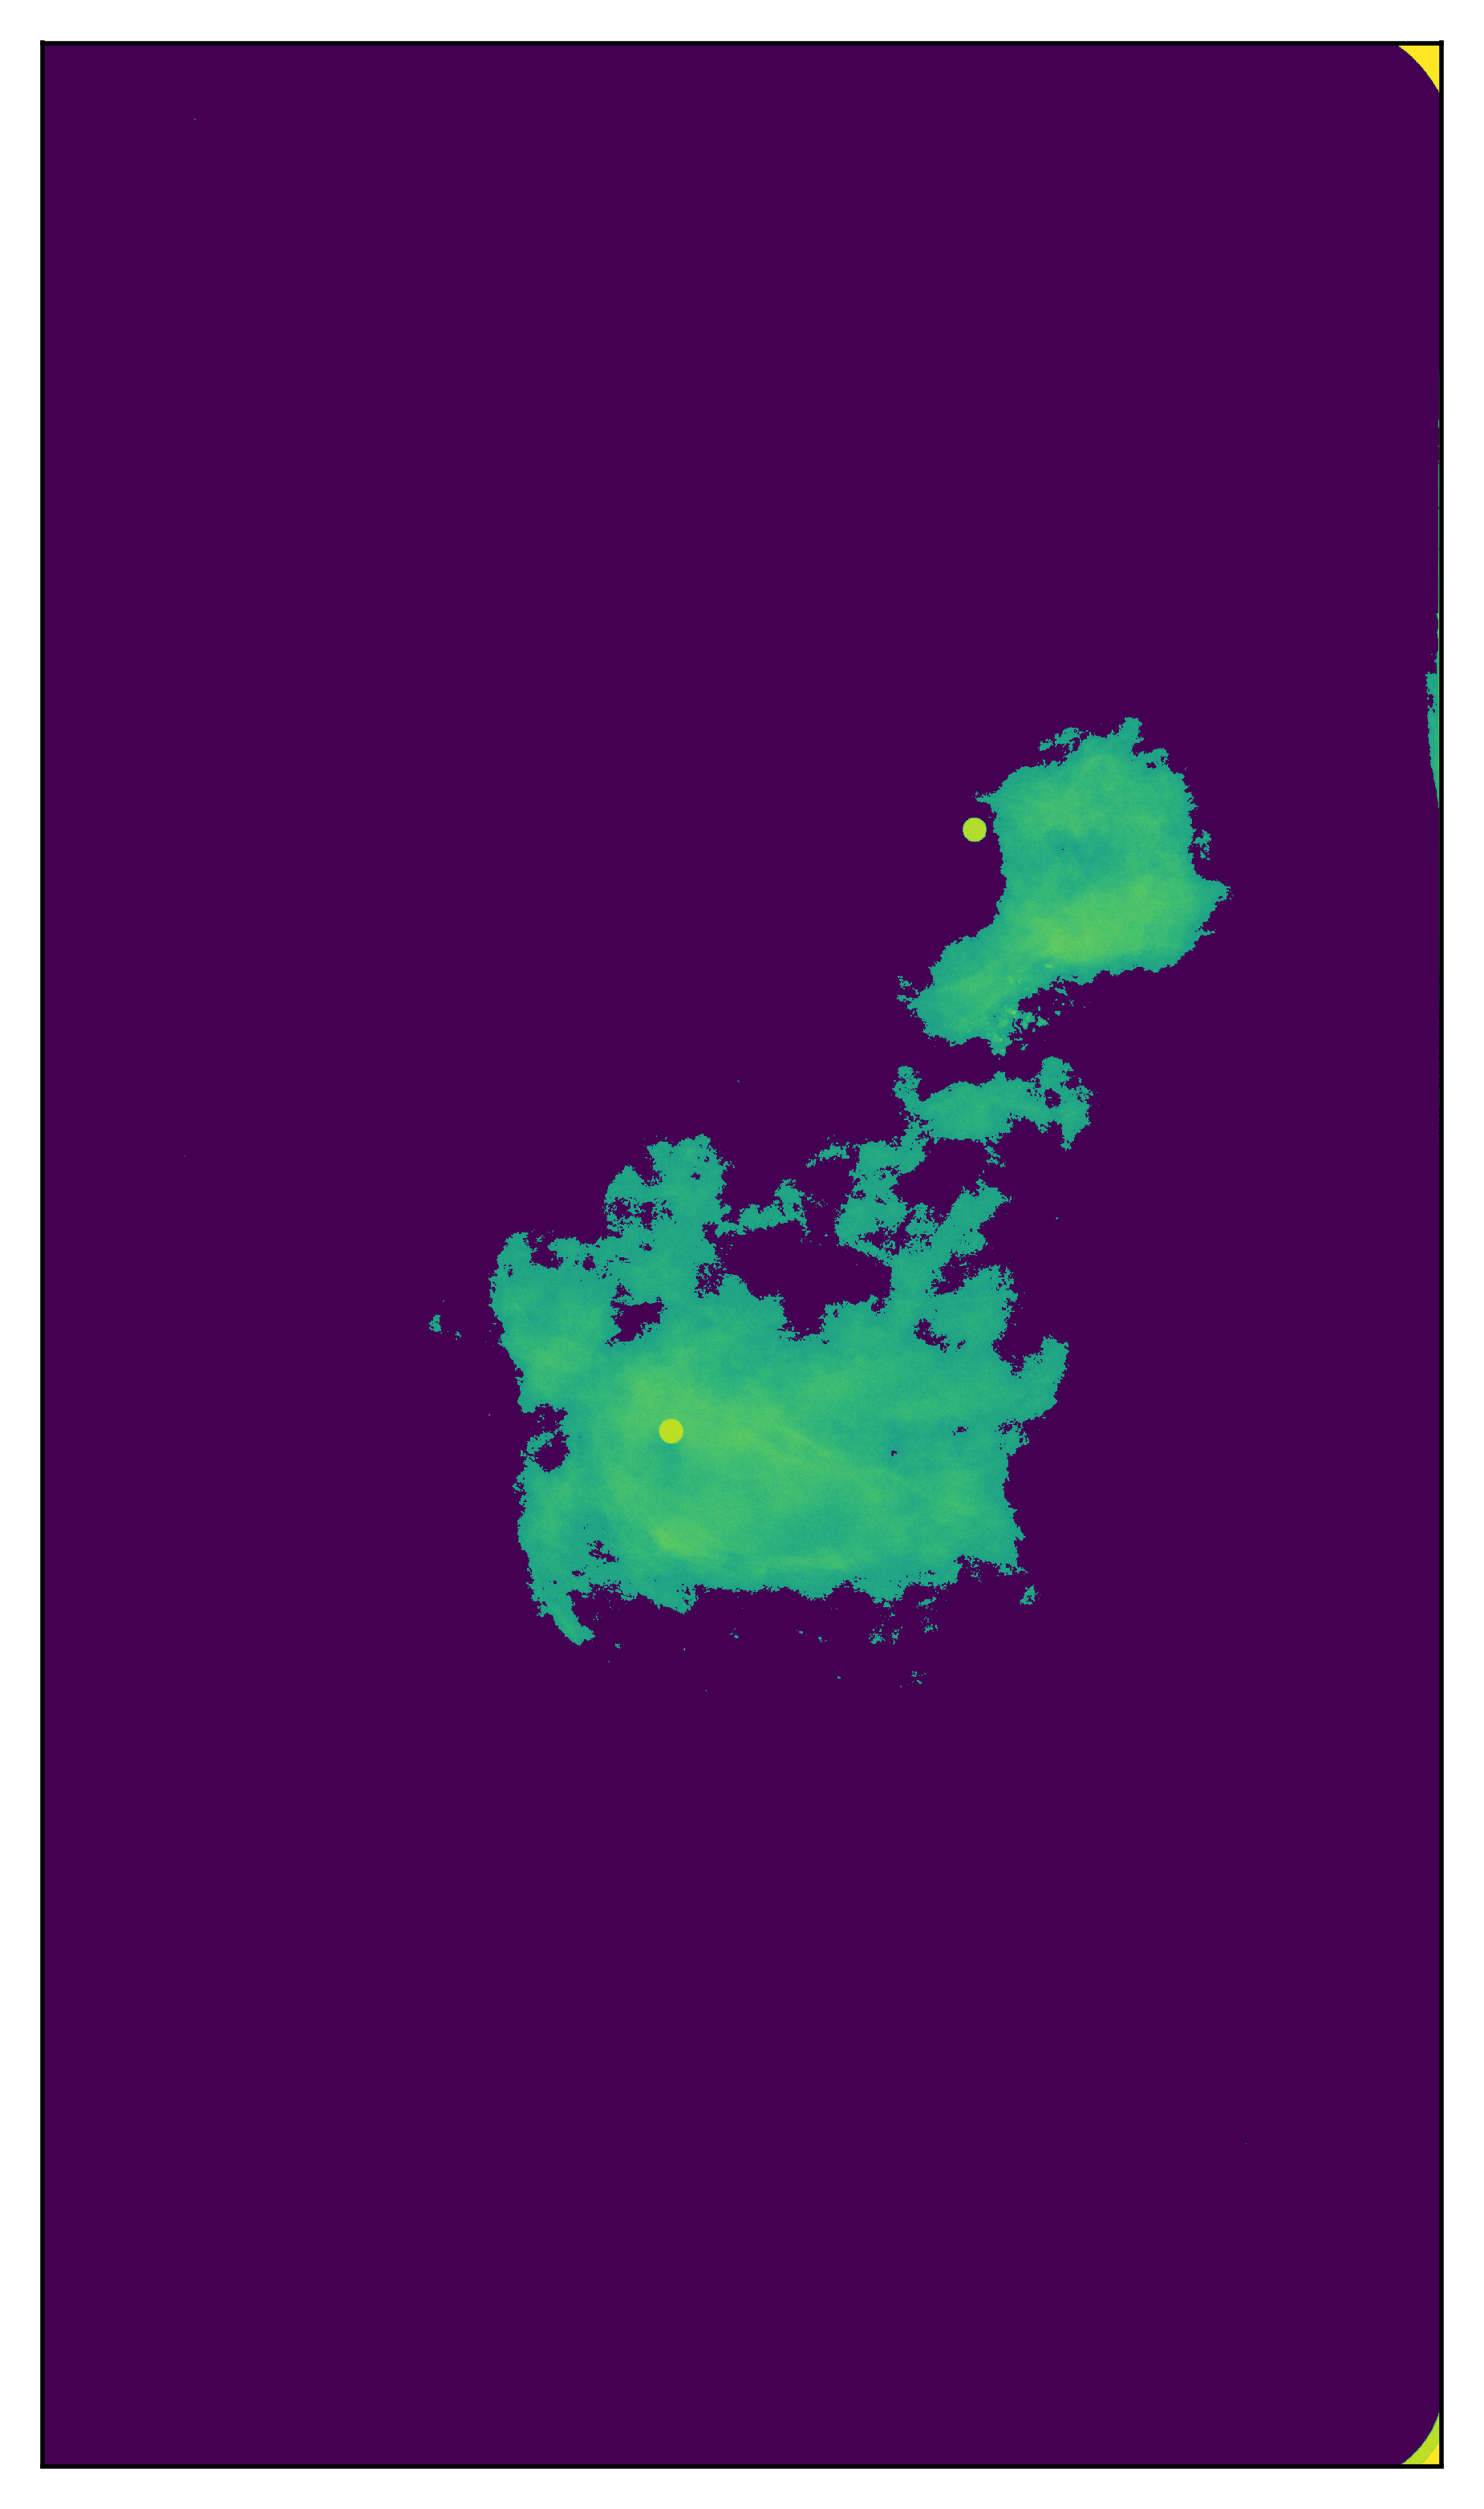

In [84]:
from numpy import *
import numpy as np
import cv2
img=cv2.imread('/Users/sunying/Desktop/cut.jpg',0)
laplace=cv2.Laplacian(img,cv2.CV_16S,ksize=5)
laplacian=cv2.convertScaleAbs(laplace)


import numpy as np
from scipy import signal

from PIL import Image
from PIL import ImageEnhance

def getGaussianElement(a,b,stda,stdb,quad=None):
    '''Create a 2d gussian weight kernel
    <a>: int, half major axis length.
    <b>: int, half minor axis length.
    <stda>, <stdb>: floats, standard deviations on x and y axis.
    <quad>: str or None. If str, choose one in the list:
            ['ne','nw','sw','se'], specifying the quadrant.
            If None, return whole disk.
    Return <ellipse>: 2d int array, gaussian weights following:
    
        f(x,y) = 1/2/pi/stda/stdb * exp(- x**2/2/stda**2 - y**2/2/stdb**2).
    '''

    assert a>0 and int(a)==a, "Major half-axis 'a' needs to be an positive integer."
    assert b>0 and int(b)==b, "Minor half-axis 'b' needs to be an positive integer."
    assert stda>0, "Standard deviation 'stda' needs to be an positive integer."
    assert stdb>0, "Standard deviation 'stdb' needs to be an positive integer."
    assert quad in [None,'ne','nw','sw','se'], "Quadrant should be one in the list [None, 'ne','nw','sw','se']."

    ax=np.arange(-a,a+1)
    bx=np.arange(-b,b+1)
    x,y=np.meshgrid(ax,bx)
    ellipse=0.5*np.pi/stda/stdb*np.exp(-x**2/2./stda**2 - y**2/2./stdb**2)

    if quad is not None:
        if quad=='ne':
            ellipse=np.where((ellipse>0) & (x>=0) & (y>=0),ellipse,0)
        elif quad=='nw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y>=0),ellipse,0)
        elif quad=='sw':
            ellipse=np.where((ellipse>0) & (x<=0) & (y<=0),ellipse,0)
        elif quad=='se':
            ellipse=np.where((ellipse>0) & (x>=0) & (y<=0),ellipse,0)

    #--------------------Normalize--------------------
    ellipse=ellipse/np.max(ellipse)

    return ellipse



class FCM():
    def __init__(self,image,n_clusters,m=2,kernel_size=5,
            kernel_shape='uniform',lam=0.5,epsilon=0.05,max_iter=300):
        '''Spatial intuitionistic Fuzzy C-means clustering on image
        <image>: 2D array, grey scale image. Can be of int type or float.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <kernel_size>: int >= 1, size of neighborhood.
        <kernel_shape>: str, 'uniform': equally weighted kernel function in
                                        summing weights in neighborhood.
                             'gaussian': gaussian weights for summing neighborhood.
        <lam>: float > 0, intuitionistic fuzzy parameter?
        <epsilon>: float > 0, threshold to check convergence.
        <max_iter>: int, max number of iterations.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if kernel_size <=0 or kernel_size != int(kernel_size):
            raise Exception("<kernel_size> needs to be positive integer.")
        if kernel_shape not in ['uniform', 'gaussian']:
            raise Exception("<kernel_shape> needs to be one of 'uniform', 'gaussian'.")
        if lam <= 0:
            raise Exception("<lam> needs to be > 0.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.kernel_size = kernel_size
        self.kernel_shape = kernel_shape
        self.lam = lam
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size
        

        #-----------------Initial weights-----------------
        self.U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            self.U[idxii,ii] = 1

        #-----------------Initial centers-----------------
        self.C = np.linspace(np.min(image),np.max(image),n_clusters)
        self.C = self.C.reshape(self.n_clusters,1)
        
         
            

        #---------------Neighbourhood kernel---------------
        if kernel_shape == 'uniform':
            self.kernel = np.ones([kernel_size,kernel_size,1])
        if kernel_shape == 'gaussian':
            radius = max(1,int(kernel_size/.2))
            stdr = max(1,int(radius/.2))
            self.kernel = getGaussianElement(radius,radius,stdr,stdr)

        #----------------Initial hesitation----------------
        self.hesitation = 1.-self.U-(1.-self.U)/(1.+2.*self.U)


    def update_U(self):
        '''Compute weights'''
        c_mesh,x_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(x_mesh-c_mesh)**power
        p2 = np.sum((1./abs(x_mesh-c_mesh))**power,axis=1)

        return 1./(p1*p2[:,None])


    def update_C(self):
        '''Compute centroid of clusters'''
        num = np.dot(self.X,self.U**self.m)
        den = np.sum(self.U**self.m,axis=0)

        return num/den


    def calculate_h(self):
        '''Compute neighbourhood weights'''
        kernel = np.ones((5,5,1))
        uu = self.U.reshape((self.shape+(self.n_clusters,)))
        h = signal.fftconvolve(uu,kernel,mode='same')
        h = h.reshape(self.U.shape)

        return h

    def compute_intuitionistic_U(self):
        '''Compute intuitionistic U'''
        self.hesitation=1.-self.U-(1-self.U)/(1+self.lam*self.U)

        return self.U+self.hesitation


    def computeNew_U(self):
        '''Compute new weights after incorporating spatial and intuitionistic'''
        p = 1
        #q = 2
        q = 3
        self.h = self.calculate_h()
        num=self.U**p*self.h**q
        denom=num.sum(axis=1)
        denom=np.outer(denom,1+np.arange(self.n_clusters))

        return num/denom


    def computeIntraDists(self):
        '''Compute mean intra cluster distances'''

        result = self.deFuzzify()
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        dist=abs(c_mesh-x_mesh)
        idx=np.arange(self.n_clusters)
        match=result[:,None]-idx[None,:]
        _,count=np.unique(self.result,return_counts=True)
        sigma=(dist*(match==0)).sum(axis=0)/count

        return sigma


    def calculate_DB_score(self):
        '''Compute DB index
        DB = 1/c * \sum_{1}^{c} max_{i != j} ( (s_i + s_j) / d_{i,j} )
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        c is the number of clusters
        '''

        sigmas = self.computeIntraDists()

        rs=sigmas[:,None]+sigmas[None,:]
        dists=abs(self.C[:,None]-self.C[None,:])
        np.fill_diagonal(dists,np.nan)
        rs=rs/dists
        ds=np.nanmax(rs,axis=0)
        DB_score=ds.sum()/self.n_clusters

        print("DB_score = %f" %DB_score)

    def calculate_D_score(self):
        '''Compute Dunn index
        D = min{ min { d_{i,j} / max {s_k} } }
        the ratio of min inter-cluster distance to max  intra-cluster distance
        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        '''

        sigmas = self.computeIntraDists()

        denom=np.max(sigmas)
        dists=abs(self.C[:,None]-self.C[None,:])/denom
        np.fill_diagonal(dists,np.inf)
        D_score=np.min(dists)

        print("D_score = %f" %D_score)


    def calculate_scores(self):

        #--------------Partition coefficient--------------
        self.vpc=(self.U**2).sum()/self.numPixels
        print("VPC =  %f" %self.vpc)

        #----------------Partition entropy----------------
        vpe=self.U*np.log(self.U)
        self.vpe=-1*vpe.sum()/self.numPixels
        print("VPE = %f" %self.vpe)

        #------------------Cost function------------------
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        numer=(self.U*(x_mesh-c_mesh)**2).sum()
        denom=self.numPixels*(self.C[0]-self.C[1])**2
        self.vxb=numer/denom
        print("VXB = %f" %self.vxb)

        #-------------DB scorea nd Dunn index-------------
        self.calculate_DB_score()
        self.calculate_D_score()


    def form_clusters(self):
        '''Iterative training'''
        d = 100
        if self.max_iter != -1:
            i = 0
            while True:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                self.U = self.compute_intuitionistic_U()
                self.U = self.computeNew_U()
                #d = sum(abs(sum(self.U_new - old_u)))
                # this way of computing d is faster
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
                #print(self.U)
        else:
            i = 0
            while d > self.epsilon:
                self.update_C()
                old_u = np.copy(self.U)
                self.update_U()
                d = sum(abs(sum(self.U - old_u)))
                print("loop : " , int(i))
                print(d)
                self.segmentImage(i)
                i+=1
        #print(self.shape)
        self.segmentImage()

    def deFuzzify(self):
        #return np.argmax(self.U[:,1], axis = 0)
        return np.argmax(self.U, axis = 1)

    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        #self.result = result
        self.result = result.reshape(self.shape).astype('int')
        print(self.result)
        
        for i in range(1,len(self.result)):
            for j in range(1,len(self.result[1])):
                if self.result[int(i)][int(j)] != 4:
                    self.result[int(i)][int(j)] = 0
                #else:
                    #self.result[int(i)][int(j)] = 1                    


                    
        return self.result




if __name__ == '__main__':

    from skimage import data

    img=data.imread('/Users/sunying/Desktop/db3/full/jpg/0+Calc-Training_P_00111_RIGHT_CC.jpg',as_grey=True)
    
    
    #img = im_crop
   
    #print(img)
    
    #img = laplacian

    cluster = FCM(img,5,m=2,epsilon=1000,max_iter=100,kernel_shape='gaussian',
            kernel_size=9)
    cluster.form_clusters()
    cluster.calculate_scores()
    result=cluster.result
    #print(result.shape)
    
    result1=multiply(mat(img),mat(result))
    #L = result1.convert('L')
    #enh_con = ImageEnhance.Contrast(result1)
    #contrast = 1.5
    #image_contrasted = enh_con.enhance(contrast)
    #-------------------Plot------------------------
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(12,8),dpi=500)

    #ax1=fig.add_subplot(1,2,1)
    #ax1.imshow(img)
    #ax1.set_title('image')

    #ax2=fig.add_subplot(1,2,2)
    #ax2=fig.add
    #ax2.imshow(result1)
    
    #ax2.set_title('segmentation')
    plt.imshow(result1)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("/Users/sunying/Desktop/result1.jpg")
    #plt.show(block=False)
    
    
        